In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')
#matplotlib.rcParams["figure.facecolor"] = "white"
#matplotlib.rcPar|ams["savefig.transparent"] = "True"


In [2]:
import pandas as pd


from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

from scipy import stats
import os
from efficacy_scripts import *




/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
from sklearn.preprocessing import scale

In [5]:
from detect_intermediates import *
from interpret_tICs import *

In [6]:
from msmbuilder.utils import verbosedump, verboseload


In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import scale
from random import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [8]:
results_dict = {}

In [9]:
def normalize_per_ligand(df):
    new_df = copy.deepcopy(df)
    n_df = new_df.ix[:, [i for i in range(0, new_df.shape[1]) if "difference" not in new_df.columns.values[i].lower()]]
    n_df = pd.DataFrame(preprocessing.scale(n_df.values, axis=1), index=n_df.index, columns=n_df.columns.values.tolist())
    new_df = pd.concat([new_df, n_df], axis=1)
    return(new_df)

In [10]:
def add_difference_columns(df):
    new_df = copy.deepcopy(df)
    for i, col_i in enumerate(df.columns):
        print(i)
        for j, col_j in enumerate(df.columns):
           if j <= i: continue
    ##        if "crystal" in col_j.lower() or "crystal" in col_i.lower(): continue
           new_df["%s-%s" %(col_j, col_i)] = new_df[col_j].subtract(new_df[col_i])
    for i, col_i in enumerate(df.columns):
        if col_i != "Active Crystal":
            new_df["Active Crystal-%s" %col_i] = new_df["Active Crystal"].subtract(new_df[col_i])
    return(new_df)

In [11]:
import multiprocessing as mp
mp.cpu_count()

12

In [12]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

150


<AsyncMapResult: chdir>

In [13]:
label_df_filename = "/home/enf/md_simulations/MOR/docking/labels_df.pkl"
label_df_filename = "/home/enf/md_simulations/MOR/docking/labels_df_pIC507.pkl"
label_df_filename = "/home/enf/md_simulations/MOR/docking/labels_df_pIC50_8_8.pkl"

with open(label_df_filename, "rb") as f:
    full_ligand_df = pickle.load(f)

In [14]:
full_ligand_df.shape

(3053, 78)

In [15]:
import pybel

fps = []
for x in full_ligand_df.smiles:
    try:
        mol = pybel.readstring("smi", x)
        fps.append(mol.calcfp(fptype='FP4'))
    except:
        fps.append(None)

full_ligand_df["fp"] = fps

In [16]:
#import grids
#reload(grids)
from grids import *

precision = "SP"

ref_receptors_dir = "/home/enf/md_simulations/MOR/bu72_ref_receptors/conformation"
active_ref_dir = "%s/bu72_ionized_pymol_RL_conformation.pdb" %ref_receptors_dir
inactive_ref_dir = "%s/bu72_aligned_4DKL_R_L_conformation.pdb" %ref_receptors_dir

analysis_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components2all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_2_regularization_wolf_autoShrinkage0pt01-backup/analysis_n_clusters25_random"
base_docking_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/docking_100clusters"
ligands_dir = "/home/enf/md_simulations/MOR/docking/ligands/32-stereoisomers_6-ring-conf"
grid_dir = "%s/grids" %base_docking_dir
docking_dir = "%s/docking_%s" %(base_docking_dir, precision)
docking_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components2all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_2_regularization_wolf_autoShrinkage0pt01-backup/all_clusterer_25clusters_1samples_samples_kdtree/docking_SP_32-stereoisomers_6-ring-conf"
#docking_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components2all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_2_regularization_wolf_autoShrinkage0pt01-backup/all_clusterer_25clusters_1samples_samples_kdtree/docking_XP"

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import analysis
from importlib import reload
reload(analysis)
from analysis import *

docking_df, poses_df = analyze_docking_results_multiple(docking_dir, precision, "%s/summary.pkl" %docking_dir, 
ligands=[n for n in get_ligands(ligands_dir, ".mae") if "_" != n[0]], poses_summary=None, redo=False, reread=False,
write_to_disk=True, worker_pool=None, parallel=True)

#docking_df, poses_df = analyze_docking_results_in_dir(docking_dir, ligands_dir, write_to_disk=True, redo=True)
docking_df[docking_df.columns] = np.nan_to_num(docking_df[docking_df.columns].values)
zeros_per_row = (docking_df == 0).sum(axis=1)
docking_df = docking_df.loc[zeros_per_row < 5]
#where_zeros = np.where(docking_df.values == 0)
#for row_index in where

#keep_cols = []
#for drug in docking_df.index:
#    if np.where(docking_df.loc[column].values == 0).shape[0] < 3:
#        keep_cols.append(col)
#docking_df = docking_df[keep_cols]


In [19]:
full_docking_df = copy.deepcopy(docking_df)
#full_docking_df = pd.concat([ref_df, docking_df[[c for c in docking_df.columns.values.tolist() if "cluster" in c]]], axis=1)
full_docking_df[full_docking_df.columns] = np.nan_to_num(full_docking_df[full_docking_df.columns].values)
new_names =  [n.replace("cluster", "State ").replace("_sample0", "") for n in full_docking_df.columns.values.tolist()]
new_names = ["Inactive Crystal", "Active Crystal"] + new_names[2:]
full_docking_df.columns = new_names
full_docking_df.index = [n.lower().strip().replace(" ", "_").replace("β", "beta").replace("α", "alpha").replace("Α", "alpha") for n in full_docking_df.index.values]
full_docking_df = full_docking_df.groupby(full_docking_df.index).first()

In [20]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)

In [21]:
common_ligands = [n for n in full_ligand_df.drop_duplicates().index.values if n.lower().strip() in full_docking_df.index.values]

In [22]:
full_ligand_df.drop_duplicates().shape

(3053, 79)

In [38]:
full_ligand_df.loc[full_ligand_df.smiles == ""].shape

(0, 64)

In [23]:
X_df = copy.deepcopy(full_docking_df)
#X_df["Active Crystal-Inactive Crystal"] = X_df["Active Crystal"].subtract(X_df["Inactive Crystal"])
#X_df = add_difference_columns(X_df)
#X_df = X_df[[n for n in X_df.columns if "difference" not in n]]
X_df = X_df.dropna().reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
C_df = X_df[[n for n in X_df.columns.values.tolist() if "State" not in n]]
#C_df = X_df[["State 1", "State 12", "State 24", "State 17", "State 22"]]

if not os.path.exists("%s/x_df.pkl" %analysis_dir):
    with open("%s/x_df.pkl" %analysis_dir, "wb") as f:
        pickle.dump(X_df, f, protocol=2)

ligand_df = copy.deepcopy(full_ligand_df[[c for c in full_ligand_df.columns.values if "fp" not in c.lower()]])
ligand_df.index = [n.lower() for n in ligand_df.index.values]
ligand_df = ligand_df.loc[[n for n in ligand_df.index.values if n in full_docking_df.index.values]]
print(full_ligand_df.shape)
print(ligand_df.shape)

ligand_df = ligand_df.loc[ligand_df.smiles.dropna().index]
ligand_df = ligand_df.loc[ligand_df.smiles != ""]
ligand_df = ligand_df.groupby(ligand_df.index).first()

mols = [pybel.readstring("smi", x) for x in ligand_df.smiles]
fps = [x.calcfp(fptype='FP4') for x in mols] # Calculate their fingerprints
ligand_df["fp"] = fps

similarity_matrix = np.zeros((len(mols), len(mols)))
remove_ligands = []
print("original ligands: %d" %ligand_df.shape[0])

for i in range(0, len(mols)):
    for j in range(i, len(mols)):
        if i == j:
            continue            
        similarity_matrix[i][j] = fps[i] | fps[j]
        if similarity_matrix[i][j] > 0.99:
            #continue
            remove_ligands.append(j)

ligand_df = ligand_df.iloc[[i for i in range(0, len(mols)) if i not in remove_ligands]]
print("kept ligands: %d" %ligand_df.shape[0])

ligand_df["label"] = ligand_df["class"]

model_agonists = ligand_df.index.values

y = ligand_df["label"].values.reshape((-1,1))
y_df = pd.DataFrame(y, index=ligand_df.index, columns=["label"]).loc[model_agonists]
y = y_df.values

n_trials = 100
train_test_split_prop = 0.9
model_type = "rfr"
def normalize_per_ligand(df):
    new_df = copy.deepcopy(df)
    n_df = new_df.ix[:, [i for i in range(0, new_df.shape[1]) if "difference" not in new_df.columns.values[i].lower()]]
    n_df = pd.DataFrame(preprocessing.scale(n_df.values, axis=1), index=n_df.index, columns=n_df.columns.values.tolist())
    new_df = pd.concat([new_df, n_df], axis=1)
    return(new_df)

normalize = False
normalize_axis0 = False
if normalize_axis0:
    double_features = 2
    new_df = normalize_per_ligand(X_df)
else: 
    new_df = X_df
    double_features = 1
n_estimators = 1000

features = [C_df.loc[model_agonists], new_df.loc[model_agonists]]#, all_features_df]#, all_features]
feature_names = ["Crystal Structures", "MSM Docking"]
print([f.shape for f in features])
#save_name = "actigve_vs_dud_%strials_%d_split%s_normalize%s_normalize-axis0%s_n-estimators%d_precision%s" %(model_type, n_trials, str(train_test_split_prop), str(normalize), str(normalize_axis0), n_estimators, precision)
save_name = "affinity_model_pIC50-8-8_chembl_none-removed_rfr_1000trees"

if not os.path.exists("%s/%s_new_df.pkl" %(analysis_dir, save_name)):
    with open("%s/%s_new_df.pkl" %(analysis_dir, save_name), "wb") as f:
        pickle.dump(new_df, f, protocol=2)

(3053, 79)
(2941, 78)
original ligands: 2824
kept ligands: 1511
[(1511, 2), (1511, 27)]


(array([ 960.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  551.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

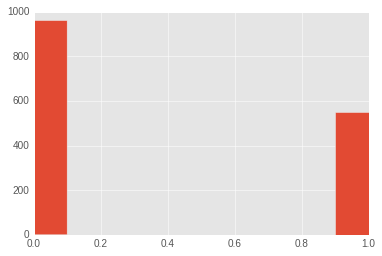

In [24]:
plt.hist(ligand_df["label"], bins=10)

In [25]:
new_df.shape

(5468, 27)

In [166]:
np.where(y == 1)[0].shape

(74,)

In [26]:
results_dict[save_name] = generate_or_load_model(features, y, feature_names,
                                                 n_trials, train_test_split_prop, False,
                                                 model_type, "%s/%s.pkl" %(analysis_dir, save_name),
                                                 redo=True, worker_pool=dview, parallel=False, n_estimators=n_estimators, 
                                                 max_depth=None, criterion='gini',
                                                 normalize=normalize, normalize_axis0=False)

Aobut to fit model(s).
Fitting models over all data...
Fitting models over split train data...
Finished fitting models


analyzing precision at full recall:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.367956          0.000000   
MSM Docking           0.387950          0.019993   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.724983387855, 0.912706544499)  


ValueError: list.remove(x): x not in list

analyzing threshold at full recall:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.024593          0.000000               (0, 0.0)
MSM Docking           0.159930          0.135337  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

analyzing Accuracy:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.583421            0.0000               (0, 0.0)
MSM Docking           0.715921            0.1325  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

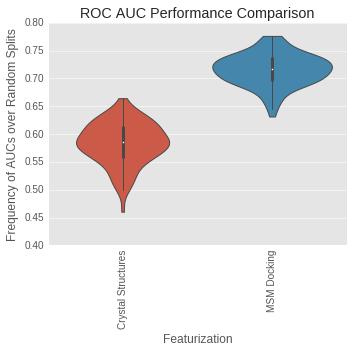

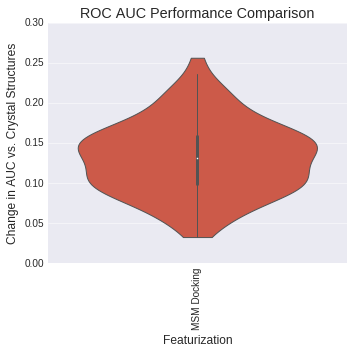

analyzing Recall:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.319818          0.000000   
MSM Docking           0.388545          0.068727   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.646891854579, 0.859508974055)  


ValueError: list.remove(x): x not in list

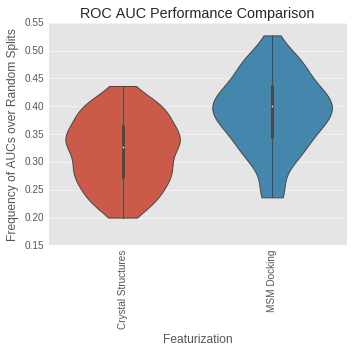

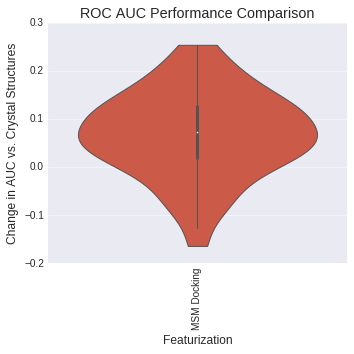

analyzing precision:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.405349          0.000000               (0, 0.0)
MSM Docking           0.693884          0.288535  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

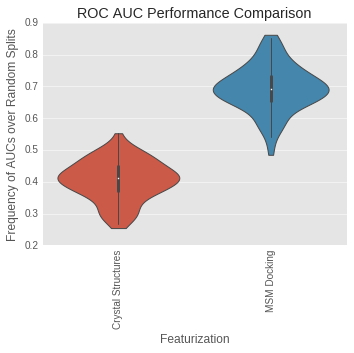

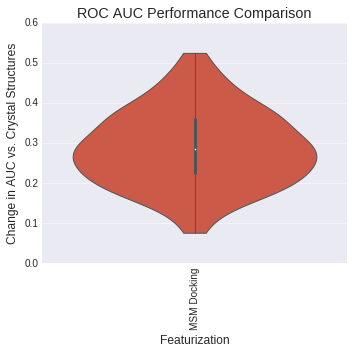

analyzing fdr:
(100, 2)
                    Median AUC  Median delta AUC        Sign Test 99% CI
Crystal Structures    0.594651          0.000000                (0, 0.0)
MSM Docking           0.306116         -0.288535  (0.0, 0.0622206877158)


ValueError: list.remove(x): x not in list

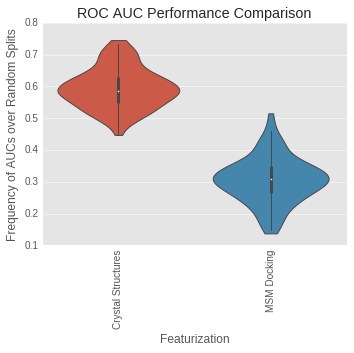

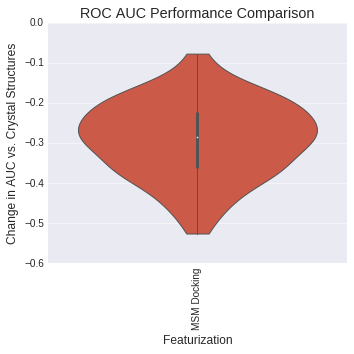

analyzing Recall:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.319818          0.000000   
MSM Docking           0.388545          0.068727   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.646891854579, 0.859508974055)  


ValueError: list.remove(x): x not in list

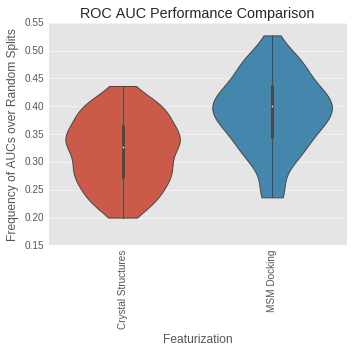

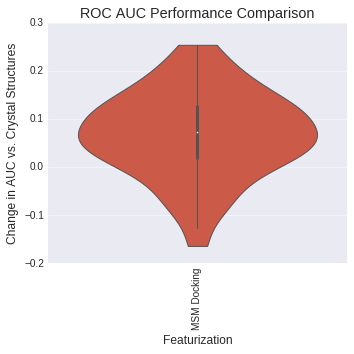

analyzing precision:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.405349          0.000000               (0, 0.0)
MSM Docking           0.693884          0.288535  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

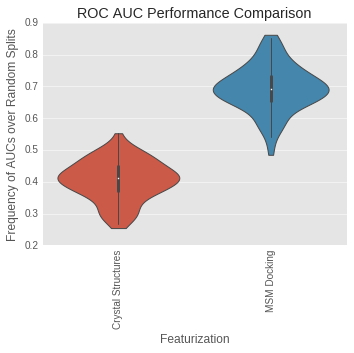

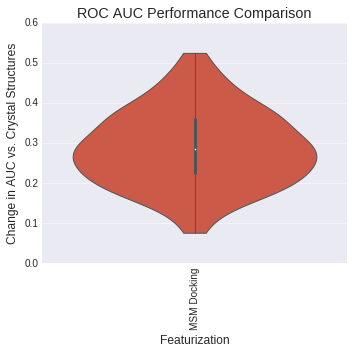

analyzing fdr:
(100, 2)
                    Median AUC  Median delta AUC        Sign Test 99% CI
Crystal Structures    0.594651          0.000000                (0, 0.0)
MSM Docking           0.306116         -0.288535  (0.0, 0.0622206877158)


ValueError: list.remove(x): x not in list

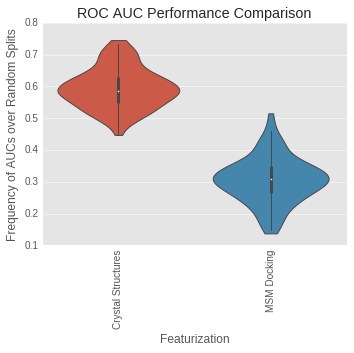

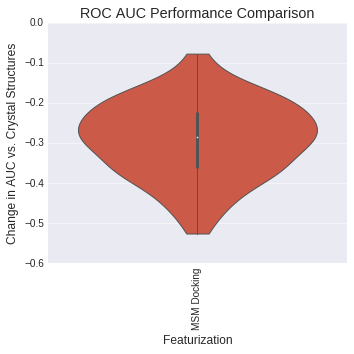

analyzing class B ROC AUC:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.543614          0.000000               (0, 0.0)
MSM Docking           0.752453          0.208839  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

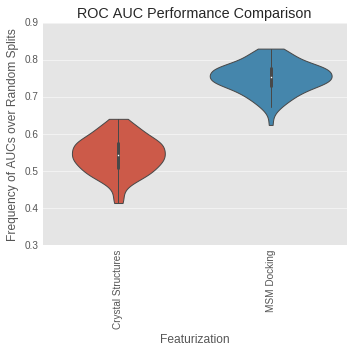

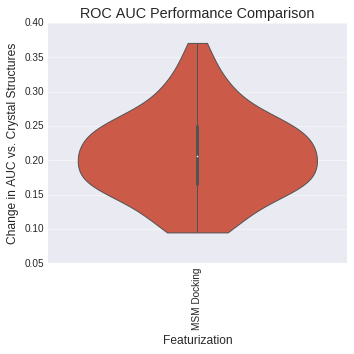

analyzing ROC AUC:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.543614          0.000000               (0, 0.0)
MSM Docking           0.752453          0.208839  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

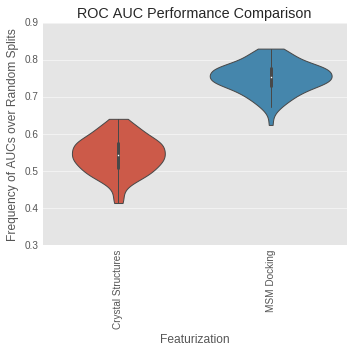

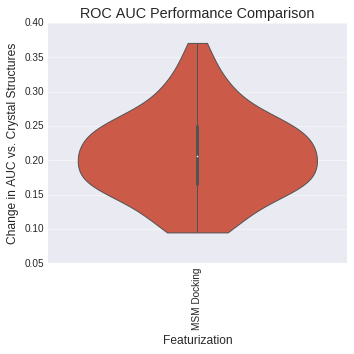

analyzing BedROC
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.426901          0.000000               (0, 0.0)
MSM Docking           0.774365          0.347464  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

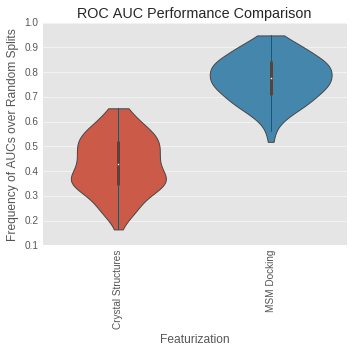

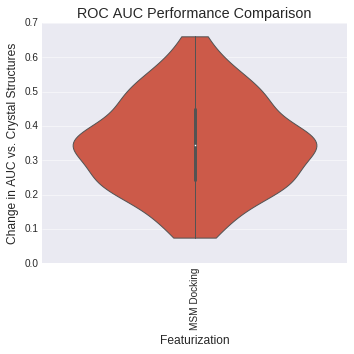

analyzing LogAUC
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.164740          0.000000               (0, 0.0)
MSM Docking           0.302406          0.137666  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

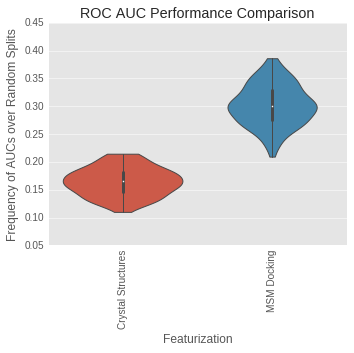

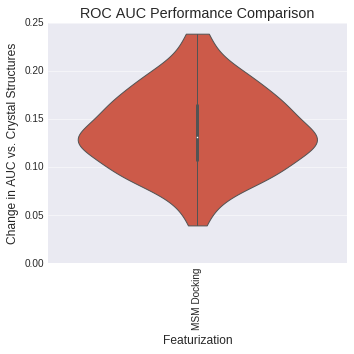

(2,)
(1, 2)


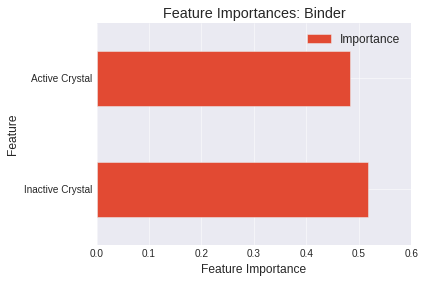

(27,)
(1, 27)


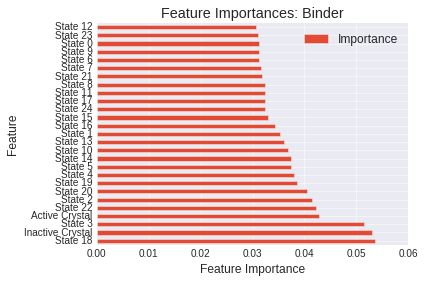

In [27]:


importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], model_agonists, analysis_dir,
                                                                ["Non-Binder", "Binder"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([new_df.loc[model_agonists].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.mean)

In [53]:
def add_difference_columns(df):
    new_df = copy.deepcopy(df)
    for i, col_i in enumerate(df.columns):
        print(i)
        for j, col_j in enumerate(df.columns):
           if j <= i: continue
    ##        if "crystal" in col_j.lower() or "crystal" in col_i.lower(): continue
           new_df["%s-%s" %(col_j, col_i)] = new_df[col_j].subtract(new_df[col_i])
    #for i, col_i in enumerate(df.columns):
    #    if col_i != "Active Crystal":
    #        new_df["Active Crystal-%s" %col_i] = new_df["Active Crystal"].subtract(new_df[col_i])
    return(new_df)

X_df = copy.deepcopy(full_docking_df)
#X_df["Active Crystal-Inactive Crystal"] = X_df["Active Crystal"].subtract(X_df["Inactive Crystal"])
#X_df = add_difference_columns(X_df)
#X_df = X_df[[n for n in X_df.columns if "difference" not in n]]
X_df = X_df.dropna().reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
C_df = X_df[[n for n in X_df.columns.values.tolist() if "State" not in n]]
#C_df = X_df[["State 1", "State 12", "State 24", "State 17", "State 22"]]

if not os.path.exists("%s/x_df.pkl" %analysis_dir):
    with open("%s/x_df.pkl" %analysis_dir, "wb") as f:
        pickle.dump(X_df, f, protocol=2)

ligand_df = copy.deepcopy(full_ligand_df[[c for c in full_ligand_df.columns.values if "fp" not in c.lower()]])
ligand_df.index = [n.lower() for n in ligand_df.index.values]
ligand_df = ligand_df.loc[[n for n in ligand_df.index.values if n in full_docking_df.index.values]]
ligand_df = ligand_df.loc[ligand_df.smiles.dropna().index]
ligand_df = ligand_df.loc[ligand_df.smiles != ""]
ligand_df = ligand_df.groupby(ligand_df.index).first()
print(full_ligand_df.shape)
print(ligand_df.shape)

mols = [pybel.readstring("smi", x) for x in ligand_df.smiles]# + [pybel.readstring("smi", x) for x in ["C=CCN1CCC23C4C(=NNC(=O)C5=CC=CC=C5)CCC2(C1CC6=C3C(=C(C=C6)O)O4)O", "COc1ccc2c(c1)C13CCCCC3C(C2)N(CC1)C"]]
fps = [x.calcfp(fptype='FP4') for x in mols] # Calculate their fingerprints
ligand_df["fp"] = fps

similarity_matrix = np.zeros((len(mols), len(mols)))
remove_ligands = set()
print("original ligands: %d" %ligand_df.shape[0])

for i in range(0, len(mols)):
    for j in range(i, len(mols)):
        if i == j:
            continue            
        similarity_matrix[i][j] = fps[i] | fps[j]
        if similarity_matrix[i][j] > 0.99:
            #continue
            remove_ligands.add(j)
remove_ligands = list(remove_ligands)
ligand_df["label"] = ligand_df["class"]
ligand_df = ligand_df.iloc[[i for i in range(0, ligand_df.shape[0]) if i not in remove_ligands]]

(3053, 79)
(2824, 78)
original ligands: 2824


In [54]:
print(ligand_df.shape)
print(len(remove_ligands))

(1511, 80)
1313


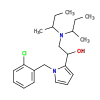

In [55]:
mols[-1]

ValueError: x and y must be the same size

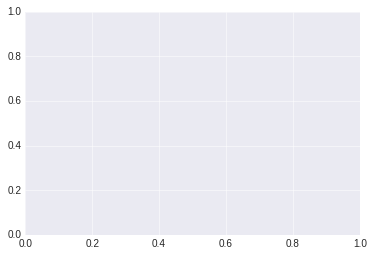

In [32]:
plt.scatter(full_docking_df.loc[common_ligands]["Active Crystal"].iloc[::10], full_ligand_df.loc[common_ligands].PCHEMBL_VALUE.iloc[::10])

In [200]:
full_docking_df.loc["cid_3345"].sor

Inactive Crystal    5.70
Active Crystal      6.15
State 0             5.55
State 10            6.25
State 11            6.00
State 12            5.23
State 13            5.54
State 14            6.08
State 15            4.77
State 16            6.16
State 17            5.50
State 18            6.00
State 19            6.16
State 1             5.48
State 20            7.04
State 21            7.42
State 22            7.07
State 23            4.33
State 24            6.44
State 2             4.64
State 3             6.62
State 4             4.93
State 5             5.81
State 6             5.60
State 7             6.30
State 8             5.85
State 9             5.58
Name: cid_3345, dtype: float64

In [240]:
similarity_matrix[:,similarity_matrix.shape[0]-2].max()

0.86363636363636365

In [57]:
model_agonists = ligand_df.index.values.tolist()

methadone_ligands = [n for n in model_agonists if "pzm" in n]
base_ligand = "pzm21"
#methadone_ligands = [n for n in model_agonists if base_ligand in n.lower()]
print(methadone_ligands)
tanimoto_cutoff = 0.7
methadone_ligands = [n for n in model_agonists if n in methadone_ligands or (ligand_df.loc[n]["fp"] | ligand_df.loc[base_ligand]["fp"]) > tanimoto_cutoff]
print("n lig of scaffold: %d" %len(methadone_ligands))

methadone_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n in methadone_ligands]
antagonists = [n for n in ligand_df.loc[ligand_df.label == 0.].index.values.tolist() if n not in methadone_ligands and (ligand_df.loc[n]["fp"] | ligand_df.loc[base_ligand]["fp"]) < (tanimoto_cutoff-.2)]
other_agonists = [n for n in ligand_df.loc[ligand_df.label == 1.].index.values.tolist() if n not in methadone_ligands and (ligand_df.loc[n]["fp"] | ligand_df.loc[base_ligand]["fp"]) < (tanimoto_cutoff-.2)]

#random.shuffle(antagonists)
#model_agonists = other_agonists + antagonists[:int(len (antagonists)*3/4)]
#ligand_df = ligand_df.loc[model_agonists]

y = ligand_df["label"].values.reshape((-1,1))
y_df = pd.DataFrame(y, index=ligand_df.index, columns=["label"]).loc[model_agonists]
y = y_df.values

names = ligand_df.index.values.tolist()
antagonist_inds = [names.index(n) for n in antagonists]
non_methadone_agonist_inds = [names.index(n) for n in other_agonists]
methadone_inds = [names.index(n) for n in methadone_agonists]

splitter = CustomSplitter(antagonist_inds,
                          non_methadone_agonist_inds,
                          methadone_inds)

n_trials = 100
train_test_split_prop = 0.9
model_type = "rfr"
def normalize_per_ligand(df):
    new_df = copy.deepcopy(df)
    n_df = new_df.ix[:, [i for i in range(0, new_df.shape[1]) if "difference" not in new_df.columns.values[i].lower()]]
    n_df = pd.DataFrame(preprocessing.scale(n_df.values, axis=1), index=n_df.index, columns=n_df.columns.values.tolist())
    new_df = pd.concat([new_df, n_df], axis=1)
    return(new_df)

normalize = False
normalize_axis0 = False
if normalize_axis0:
    double_features = 2
    new_df = normalize_per_ligand(X_df)
else: 
    new_df = X_df
    double_features = 1
n_estimators = 1000

features = [C_df.loc[model_agonists], new_df.loc[model_agonists]]#, all_features_df]#, all_features]
feature_names = ["Crystal Structures", "MSM Docking"]
print([f.shape for f in features])
save_name = "actigve_vs_dud_%strials_%d_split%s_normalize%s_normalize-axis0%s_n-estimators%d_precision%s" %(model_type, n_trials, str(train_test_split_prop), str(normalize), str(normalize_axis0), n_estimators, precision)

if not os.path.exists("%s/%s_new_df.pkl" %(analysis_dir, save_name)):
    with open("%s/%s_new_df.pkl" %(analysis_dir, save_name), "wb") as f:
        pickle.dump(new_df, f, protocol=2)

['pzm21']
n lig of scaffold: 5
[(1511, 2), (1511, 27)]


In [60]:
methadone_ligands

['chembl219317', 'chembl287981', 'chembl40528', 'chembl40548', 'pzm21']

In [62]:
methadone_agonists

['chembl40548', 'pzm21']

In [135]:
full_ligand_df.index.values.tolist()

['cid_27200',
 'chembl3219940',
 'chembl3665444',
 'cid_10206324',
 'cid_148123',
 'cid_4943',
 'cid_4601',
 'chembl2370996',
 'cid_4235',
 'cid_6473881',
 'cid_36294',
 'cid_4488',
 'cid_5978',
 'cid_3957',
 'cid_2803',
 'chembl3670294',
 'cid_9812710',
 'cid_3385',
 'cid_84029',
 'cid_12560',
 'cid_13342',
 'cid_42008',
 'cid_5833',
 'chembl428276',
 'cid_7057919',
 'cid_5775',
 'cid_441243',
 'cid_3324',
 'cid_68782313',
 'chembl2369408',
 'cid_5717',
 'cid_667550',
 'cid_82153',
 'cid_14385',
 'cid_5245',
 'chembl8072',
 'cid_41781',
 'cid_64715',
 'cid_2708',
 'cid_10388166',
 'cid_4485',
 'cid_39912',
 'chembl3330676',
 'cid_1549041',
 'chembl320804',
 'cid_39468',
 'cid_444',
 'cid_679',
 'cid_44574671',
 'cid_5566',
 'cid_5591',
 'cid_5467',
 'cid_5430',
 'cid_2749',
 'cid_54670067',
 'cid_3728',
 'cid_11266170',
 'cid_2132',
 'cid_3168',
 'cid_2882',
 'chembl524522',
 'cid_44426828',
 'chembl3704631',
 'cid_2244',
 'cid_5281007',
 'cid_5104',
 'cid_10252647',
 'cid_667750',
 '

In [138]:
full_ligand_df.loc["cid_5288826"]

MOLREGNO                                                                                                                                                   6005
PARENT_CMPD_CHEMBLID                                                                                                                                   CHEMBL70
PARENT_MOLREGNO                                                                                                                                            6005
MOL_PREF_NAME                                                                                                                                          MORPHINE
COMPOUND_KEY                                                                                                                                           Morphine
MOLWEIGHT                                                                                                                                                285.34
ALOGP                                   

In [59]:
print(len(antagonist_inds))
print(len(non_methadone_agonist_inds))
print(len(methadone_inds))

809
489
2


In [28]:
y_true = ligand_df["label"].sort("label", inplace=False, ascending=True)
rocs = [roc_auc_score(y_true.values, new_df.loc[y_true.index.values.tolist()][col].values) for col in new_df.columns]
roc_df = pd.DataFrame(rocs, columns=["aucs"], index=new_df.columns.values).sort("aucs", inplace=False)
roc_df


,aucs
State 3,0.417183
State 18,0.417821
State 22,0.422574
State 21,0.449324
State 2,0.449361
State 20,0.450948
State 10,0.452753
State 7,0.457811
State 16,0.459265
State 14,0.461680


In [64]:
full_docking_df.loc["pzm21"]

Inactive Crystal    6.97
Active Crystal      6.10
State 0             6.05
State 10            5.88
State 11            5.81
State 12            7.44
State 13            5.95
State 14            6.36
State 15            6.22
State 16            6.85
State 17            6.42
State 18            6.85
State 19            5.94
State 1             7.52
State 20            7.56
State 21            6.29
State 22            7.44
State 23            4.42
State 24            6.42
State 2             5.92
State 3             6.14
State 4             5.66
State 5             5.83
State 6             6.26
State 7             7.35
State 8             6.60
State 9             6.26
Name: pzm21, dtype: float64

(array([    3.,     5.,    47.,   476.,  2036.,  2063.,   582.,   176.,
           64.,    16.]),
 array([  0.   ,   1.383,   2.766,   4.149,   5.532,   6.915,   8.298,
          9.681,  11.064,  12.447,  13.83 ]),
 <a list of 10 Patch objects>)

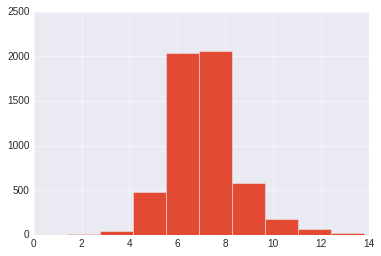

In [49]:
plt.hist(full_docking_df["State 20"])

In [52]:
ligand_df["label"]

14-ethoxymetopon                    1.0
3-allylfentanyl                     1.0
3-methylbutyrfentanyl               1.0
3-methylthiofentanyl                1.0
4-fluorobutyrfentanyl               1.0
4-fluoropethidine                   1.0
4-methoxybutyrfentanyl              1.0
4-phenylfentanyl                    1.0
6-methylenedihydrodesoxymorphine    1.0
6-monoacetylmorphine                1.0
7-pet                               1.0
acrylfentanyl                       1.0
ah-7921                             1.0
alfentanil                          1.0
alimadol                            1.0
allylnorpethidine                   1.0
allylprodine                        1.0
alphacetylmethadol                  1.0
alphamethadol                       1.0
alphamethylthiofentanyl             1.0
alvimopan                           1.0
anileridine                         1.0
at-076                              1.0
axelopran                           1.0
azaprocin                           1.0


In [ ]:
roc_auc_score(y_true.values, new_df.loc[y_true.index.values.tolist()].mean(axis=1).values)

Aobut to fit model(s).
Fitting models over all data...
Fitting models over split train data...
Finished fitting models
analyzing precision at full recall:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.539000          0.000000   
MSM Docking           0.726333          0.187333   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.521325733492, 0.760008060193)  


ValueError: list.remove(x): x not in list

analyzing threshold at full recall:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures     0.26635            0.0000               (0, 0.0)
MSM Docking            0.37565            0.1093  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

analyzing Accuracy:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures       0.654             0.000   
MSM Docking              0.556            -0.098   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.0525332877982, 0.21599884862)  


ValueError: list.remove(x): x not in list

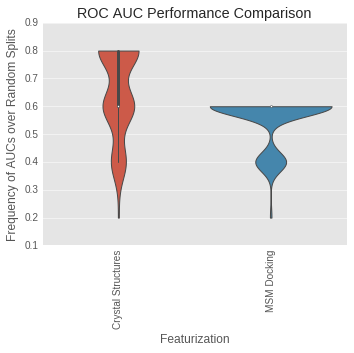

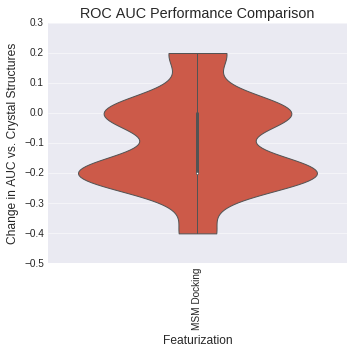

analyzing Recall:
(100, 2)
                    Median AUC  Median delta AUC        Sign Test 99% CI
Crystal Structures         0.5               0.0                (0, 0.0)
MSM Docking                0.0              -0.5  (0.0, 0.0622206877158)


ValueError: list.remove(x): x not in list

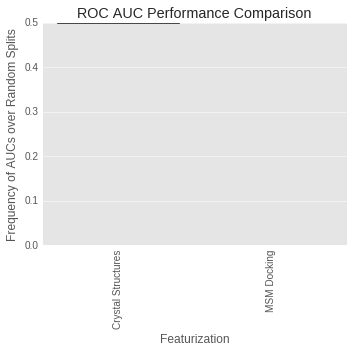

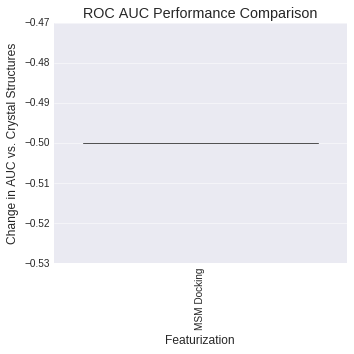

analyzing precision:
(100, 2)
                    Median AUC  Median delta AUC        Sign Test 99% CI
Crystal Structures    0.699167          0.000000                (0, 0.0)
MSM Docking           0.000000         -0.699167  (0.0, 0.0622206877158)


ValueError: list.remove(x): x not in list

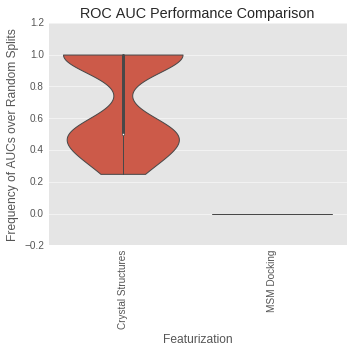

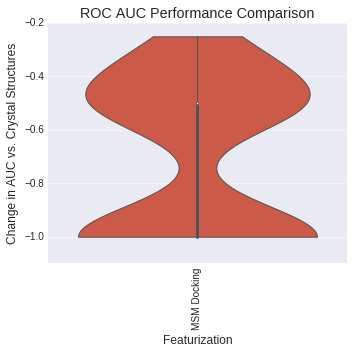

analyzing fdr:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.300833          0.000000               (0, 0.0)
MSM Docking           1.000000          0.699167  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

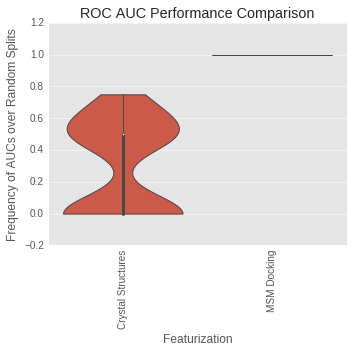

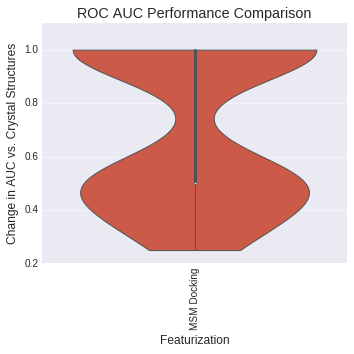

analyzing Recall:
(100, 2)
                    Median AUC  Median delta AUC        Sign Test 99% CI
Crystal Structures         0.5               0.0                (0, 0.0)
MSM Docking                0.0              -0.5  (0.0, 0.0622206877158)


ValueError: list.remove(x): x not in list

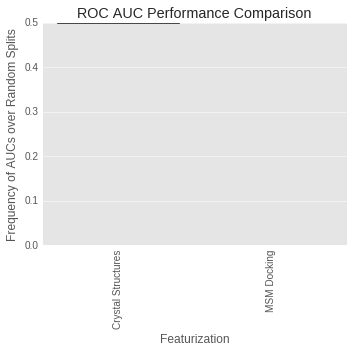

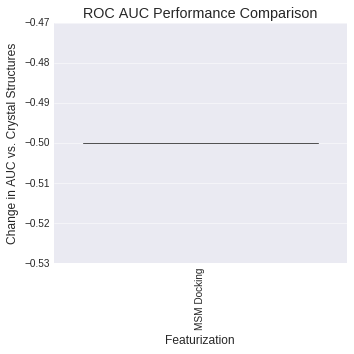

analyzing precision:
(100, 2)
                    Median AUC  Median delta AUC        Sign Test 99% CI
Crystal Structures    0.699167          0.000000                (0, 0.0)
MSM Docking           0.000000         -0.699167  (0.0, 0.0622206877158)


ValueError: list.remove(x): x not in list

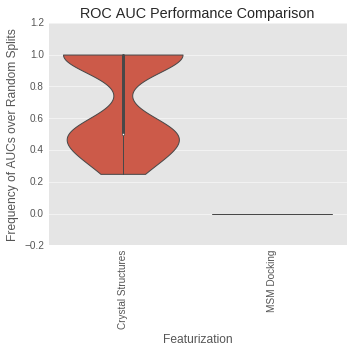

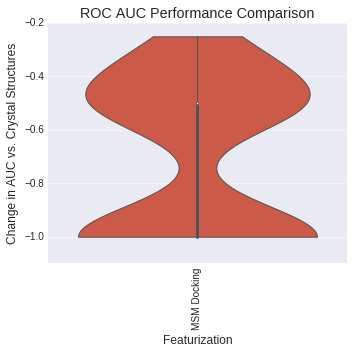

analyzing fdr:
(100, 2)
                    Median AUC  Median delta AUC       Sign Test 99% CI
Crystal Structures    0.300833          0.000000               (0, 0.0)
MSM Docking           1.000000          0.699167  (0.937779312284, 1.0)


ValueError: list.remove(x): x not in list

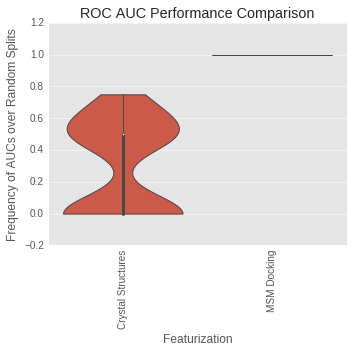

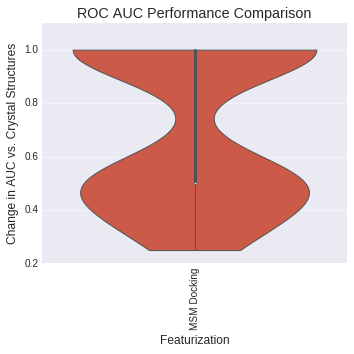

analyzing class B ROC AUC:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.623333              0.00   
MSM Docking           0.693333              0.07   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.365925226154, 0.615319187601)  


ValueError: list.remove(x): x not in list

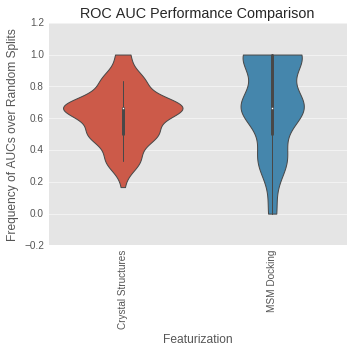

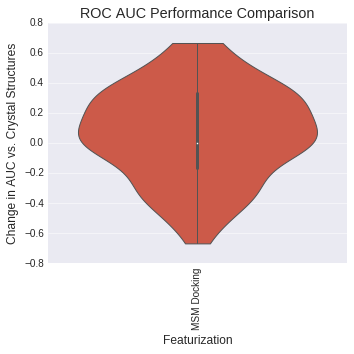

analyzing ROC AUC:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.623333              0.00   
MSM Docking           0.693333              0.07   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.365925226154, 0.615319187601)  


ValueError: list.remove(x): x not in list

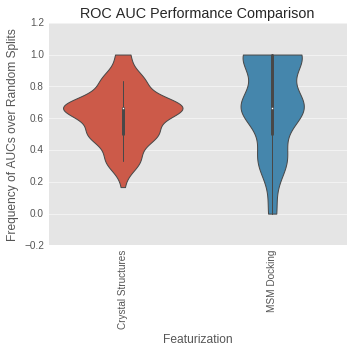

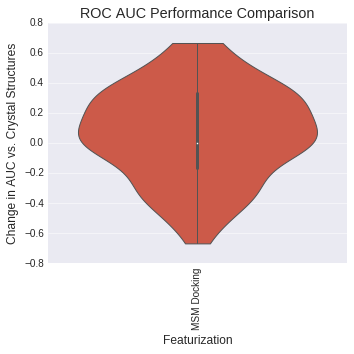

analyzing BedROC
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.673788          0.000000   
MSM Docking           0.406121         -0.267667   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.338143288421, 0.586834366596)  


ValueError: list.remove(x): x not in list

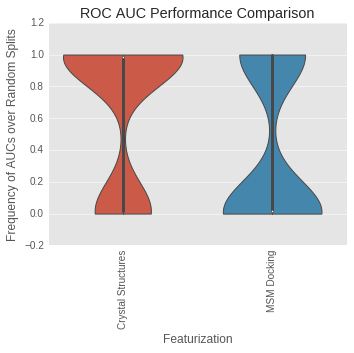

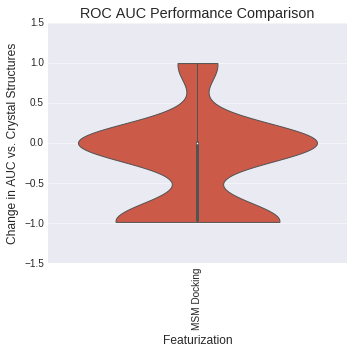

analyzing LogAUC
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.078481          0.000000   
MSM Docking           0.080250          0.001769   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.239991939807, 0.478674266508)  


ValueError: list.remove(x): x not in list

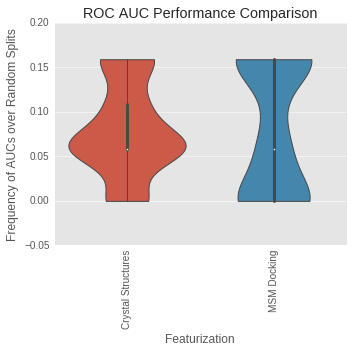

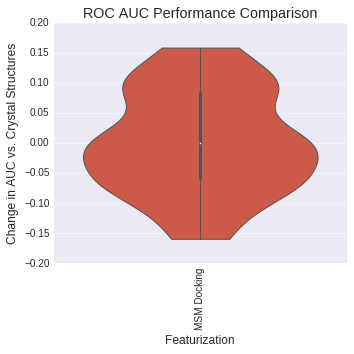

(2,)
(1, 2)


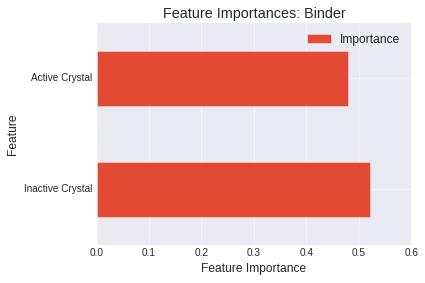

(27,)
(1, 27)


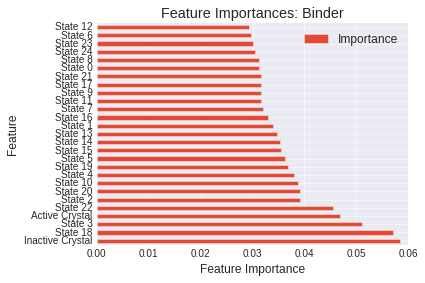

In [63]:
n_trials = 100
model_type = "rfr"
#pzm21 split
results_dict[save_name] = generate_or_load_model([f.values for f in features], y, feature_names,
                                                 n_trials, train_test_split_prop, False,
                                                 model_type, "%s/%s.pkl" %(analysis_dir, save_name),
                                                 redo=True, worker_pool=dview, parallel=False, n_estimators=n_estimators, 
                                                 max_depth=None, criterion='gini',
                                                 normalize=normalize, normalize_axis0=False,
                                                 splitter=splitter)

importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], model_agonists, analysis_dir,
                                                                ["Non-Binder", "Binder"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([new_df.loc[model_agonists].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.mean)

In [ ]:
importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], model_agonists, analysis_dir,
                                                                ["Non-Binder", "Binder"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([new_df.loc[model_agonists].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.mean)

analyzing precision at full recall:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.777402          0.000000   
MSM Docking           0.770108         -0.007294   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.531463787113, 0.768625592818)  


ValueError: list.remove(x): x not in list

analyzing threshold at full recall:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.406433          0.000000   
MSM Docking           0.271849         -0.134583   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.248662880204, 0.488758912356)  


ValueError: list.remove(x): x not in list

analyzing Accuracy:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.806703           0.00000   
MSM Docking           0.836374           0.02967   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.562209266861, 0.794146871807)  


ValueError: list.remove(x): x not in list

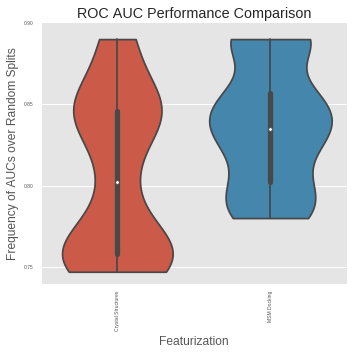

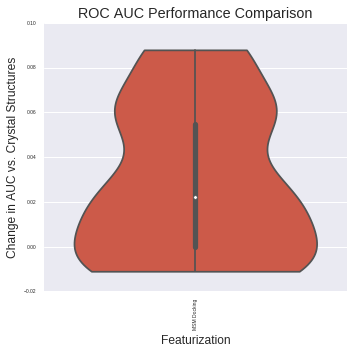

analyzing Recall:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.943934          0.000000   
MSM Docking           0.949508          0.005574   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.471419117931, 0.716136744526)  


ValueError: list.remove(x): x not in list

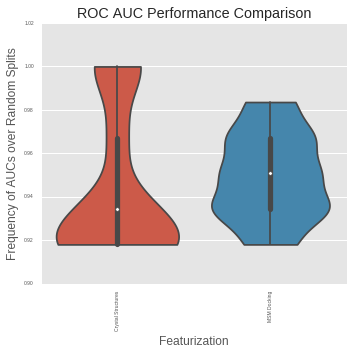

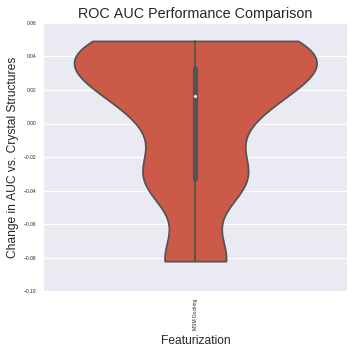

analyzing precision:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.803787          0.000000   
MSM Docking           0.832734          0.028947   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.771919554171, 0.940792723165)  


ValueError: list.remove(x): x not in list

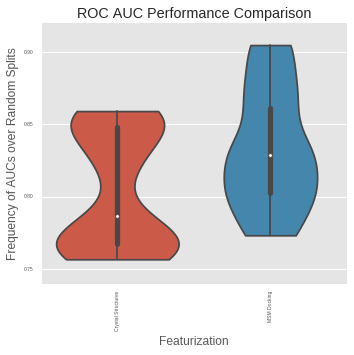

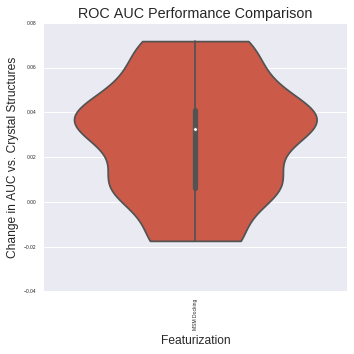

analyzing fdr:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.196213          0.000000   
MSM Docking           0.167266         -0.028947   

                                     Sign Test 99% CI  
Crystal Structures                           (0, 0.0)  
MSM Docking         (0.0592072768353, 0.228080445829)  


ValueError: list.remove(x): x not in list

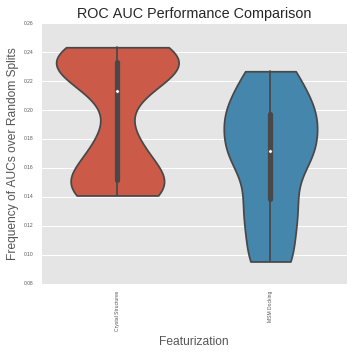

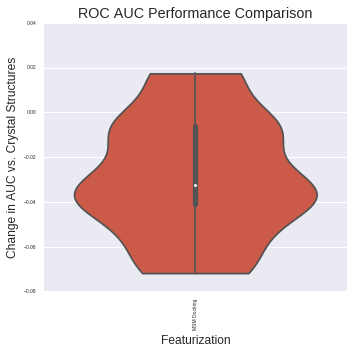

analyzing Recall:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.943934          0.000000   
MSM Docking           0.949508          0.005574   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.471419117931, 0.716136744526)  


ValueError: list.remove(x): x not in list

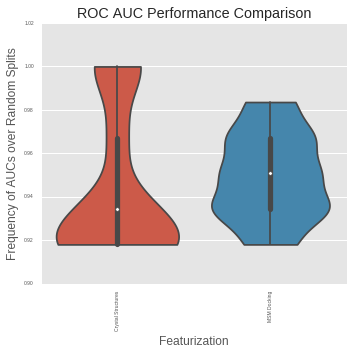

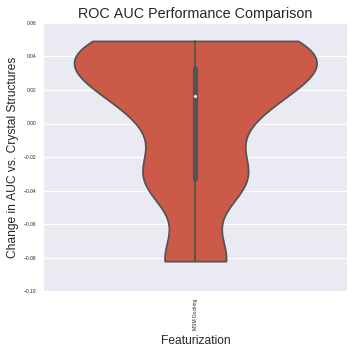

analyzing precision:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.803787          0.000000   
MSM Docking           0.832734          0.028947   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.771919554171, 0.940792723165)  


ValueError: list.remove(x): x not in list

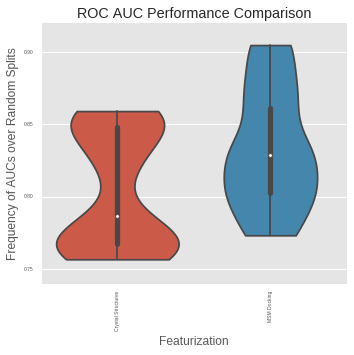

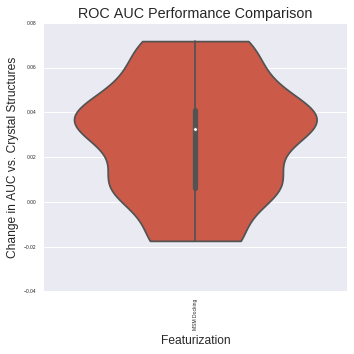

analyzing fdr:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.196213          0.000000   
MSM Docking           0.167266         -0.028947   

                                     Sign Test 99% CI  
Crystal Structures                           (0, 0.0)  
MSM Docking         (0.0592072768353, 0.228080445829)  


ValueError: list.remove(x): x not in list

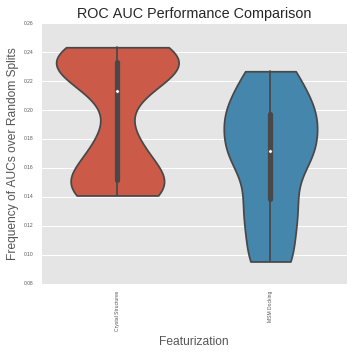

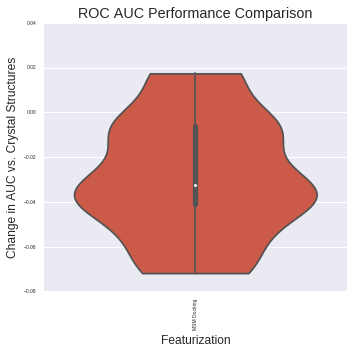

analyzing class B ROC AUC:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.849098          0.000000   
MSM Docking           0.876590          0.027492   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.771919554171, 0.940792723165)  


ValueError: list.remove(x): x not in list

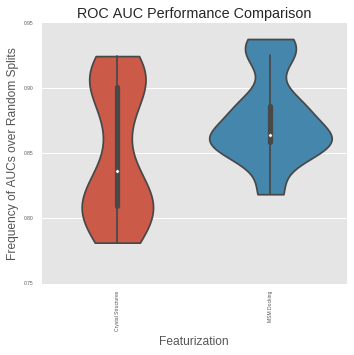

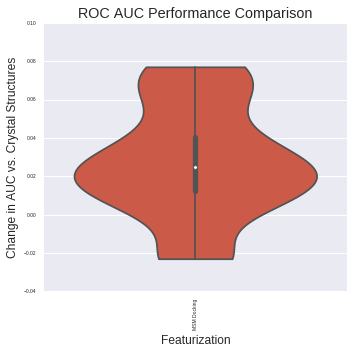

analyzing ROC AUC:
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.849098          0.000000   
MSM Docking           0.876590          0.027492   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.771919554171, 0.940792723165)  


ValueError: list.remove(x): x not in list

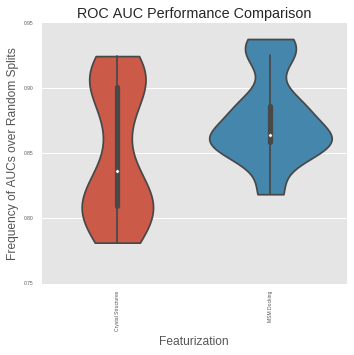

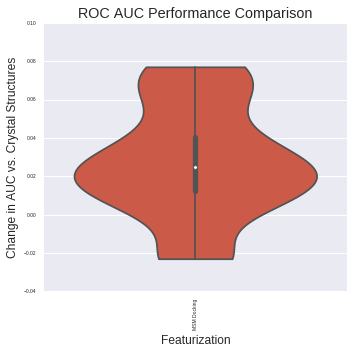

analyzing BedROC
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.977785          0.000000   
MSM Docking           0.957686         -0.020099   

                                   Sign Test 99% CI  
Crystal Structures                         (0, 0.0)  
MSM Docking         (0.32897683787, 0.577245230902)  


ValueError: list.remove(x): x not in list

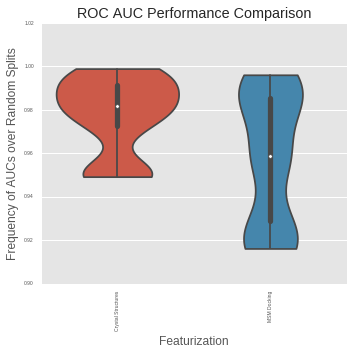

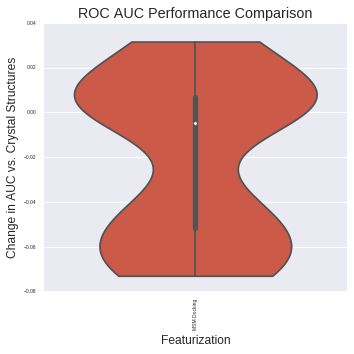

analyzing LogAUC
(100, 2)
                    Median AUC  Median delta AUC  \
Crystal Structures    0.321710          0.000000   
MSM Docking           0.363699          0.041989   

                                    Sign Test 99% CI  
Crystal Structures                          (0, 0.0)  
MSM Docking         (0.771919554171, 0.940792723165)  


ValueError: list.remove(x): x not in list

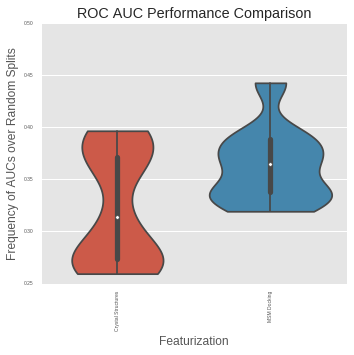

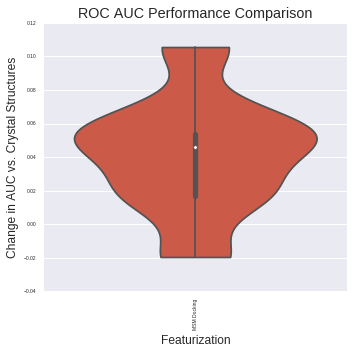

(1, 5)
(1, 5)


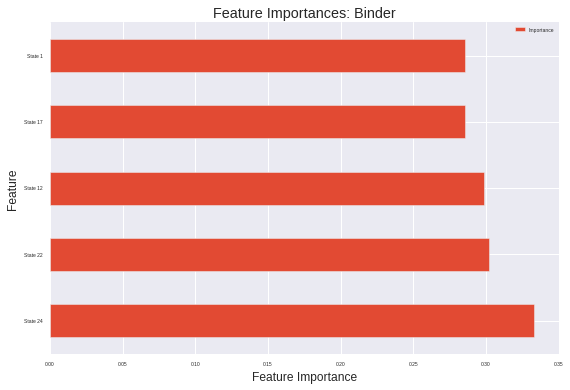

(1, 27)
(1, 27)


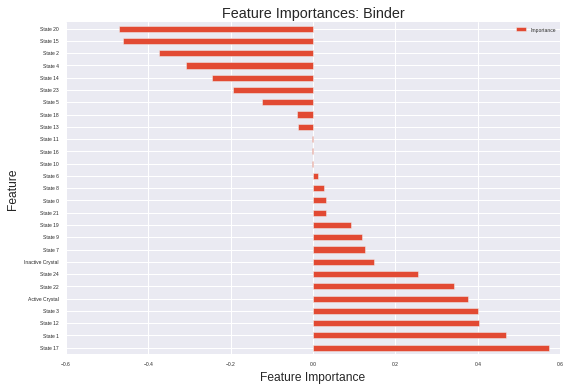

In [54]:
#logistic_cv
importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], model_agonists, analysis_dir,
                                                                ["Non-Binder", "Binder"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([new_df.loc[model_agonists].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.mean)

In [63]:
model = results_dict[save_name]['MSM Docking'][0]
y_proba =model.predict_proba(new_df.loc[[n for n in new_df.index if n not in model_agonists and n in full_ligand_df.index]].values)
test_df = pd.DataFrame(y_proba, index=[n for n in new_df.index if n not in model_agonists and n in full_ligand_df.index], columns=["Non-binder", "Binder"]).sort("Binder", ascending=False, inplace=False)


In [110]:
test_ligands = methadone_agonists+antagonists[int(len(antagonists)*3/4):]
test_df = pd.DataFrame(results_dict[save_name]["MSM Docking"][0].predict_proba(new_df), index=new_df.index, columns=["antagonist", "agonist"])
test_df["class"] = full_ligand_df.loc[test_ligands]["class"]
print(roc_auc_score(full_ligand_df.loc[test_ligands]["class"].values.reshape((-1,1)), test_df.loc[test_ligands].values[:,1]))

0.618510928962


In [111]:
test_df.loc[test_ligands].sort("agonist", inplace=False)

,antagonist,agonist,class
index,,,
cid_5921,1.000,0.000,0.0
cid_6421,1.000,0.000,0.0
cid_7858,1.000,0.000,0.0
cid_6101868,1.000,0.000,0.0
cid_3039,0.999,0.001,0.0
cid_1221,0.998,0.002,0.0
cid_22475,0.998,0.002,0.0
cid_6209,0.998,0.002,0.0
cid_71851,0.998,0.002,0.0


In [ ]:
model = results_dict[save_name]['Crystal Structures'][0]
y_proba =model.predict_proba(C_df.loc[[n for n in new_df.index if n not in model_agonists and n in full_ligand_df.index]].values)
test_df = pd.DataFrame(y_proba, index=[n for n in new_df.index if n not in model_agonists and n in full_ligand_df.index], columns=["Non-binder", "Binder"]).sort("Binder", ascending=False, inplace=False)

In [ ]:
common_ligands = [n for n in full_ligand_df.drop_duplicates().index.values if n.lower().strip() in full_docking_df.index.values]


In [52]:
y_true = ligand_df["label"].sort("label", inplace=False, ascending=True)
rocs = [roc_auc_score(y_true.values.reshape((-1,1)), new_df.loc[y_true.index.values.tolist()][col].values) for col in new_df.columns]
roc_df = pd.DataFrame(rocs, columns=["aucs"], index=new_df.columns.values).sort("aucs", inplace=False)
roc_df

,aucs
State 2,0.618234
State 14,0.642029
State 20,0.670536
State 23,0.674303
State 4,0.677955
State 15,0.682996
State 13,0.701692
State 21,0.706543
State 5,0.714553
State 0,0.718755


In [ ]:
from efficacy_scripts import *
smiles_list, compound_names, pc_smiles, pc_names = convert_sdfs_to_compounds(["/home/enf/htbc/sdfs/%s.sdf" %f for f in test_df.index.values], parallel=True, worker_pool=dview)
smiles_list = [s.strip() for s in smiles_list]
pc_smiles = [s.strip() for s in pc_smiles]
compound_names_df = pd.DataFrame(list(zip(smiles_list, compound_names, pc_smiles, pc_names)), index=test_df.index, columns=["smiles", "pubchem_name", "pubchem_smiles", "alternate_name"])
#for lig in p_bias_df.loc[[n for n in p_bias_df.index.values.tolist() if "_" == n[0]]].index.values[:100]:
#    for mol in pb.readfile("sdf", "/home/enf/htbc/sdfs/%s.sdf" %lig):
#        a = str(mol)
#        break
#    c = get_compounds(a, namespace='smiles')
    #print(c[0].synonyms)

In [ ]:
test_df[["pubchem_name", "smiles", "alternate_smiles", "alternate_name"]] = compound_names_df.loc[test_df.index][["pubchem_name", "smiles", "pubchem_smiles", "alternate_name"]]
bret_pred_df = test_df.loc[[n for n in test_df.index.values if n in common_ligands]]
bret_pred_df["label"] = 0.
bret_pred_df["label"].loc[common_ligands] = y
from rdkit.ML.Scoring.Scoring import CalcAUC
CalcAUC(bret_pred_df.values[:,(0,1)], col=0)#, alpha=10)

In [ ]:
test_df.loc[[n for n in test_df.index.values if "compd0" in n or "compd11" in n]].sort("class B", ascending=False,inplace=False).iloc[:]